In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [27]:
# read training data 
df = pd.read_csv('../data/member_daily_training.csv', parse_dates = ['date'], index_col = ['date'])

# print adfuller outptut
def adfuller_outptut(lbl, df):  

    # Augmented Dickey-Fuller calculation
    result = adfuller(df[lbl])
    
    print('ADF Statistic: {}'.format(result[0]))
    print('p-value: {}'.format(result[1]))
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t{}: {}'.format(key, value))

# check for stationarity        
def get_stationarity(timeseries, plotLabel, pltName):
    
    # rolling statistics
    rolling_mean = timeseries.rolling(window=30).mean()
    rolling_std = timeseries.rolling(window=30).std()
    
    # rolling statistics plot
    fig, ax = plt.subplots(figsize=(30,10))
    original = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(rolling_mean, color='red', label='Rolling Mean')
    std = plt.plot(rolling_std, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title(plotLabel)
    plt.show(block=False)
    plt.savefig(pltName)
    

    adfuller_outptut('number of users', timeseries)

get_stationarity(df, 'Rolling Mean & Standard Deviation: Initial dataset', '../Figures/rolling_mean_std_init_values.png')

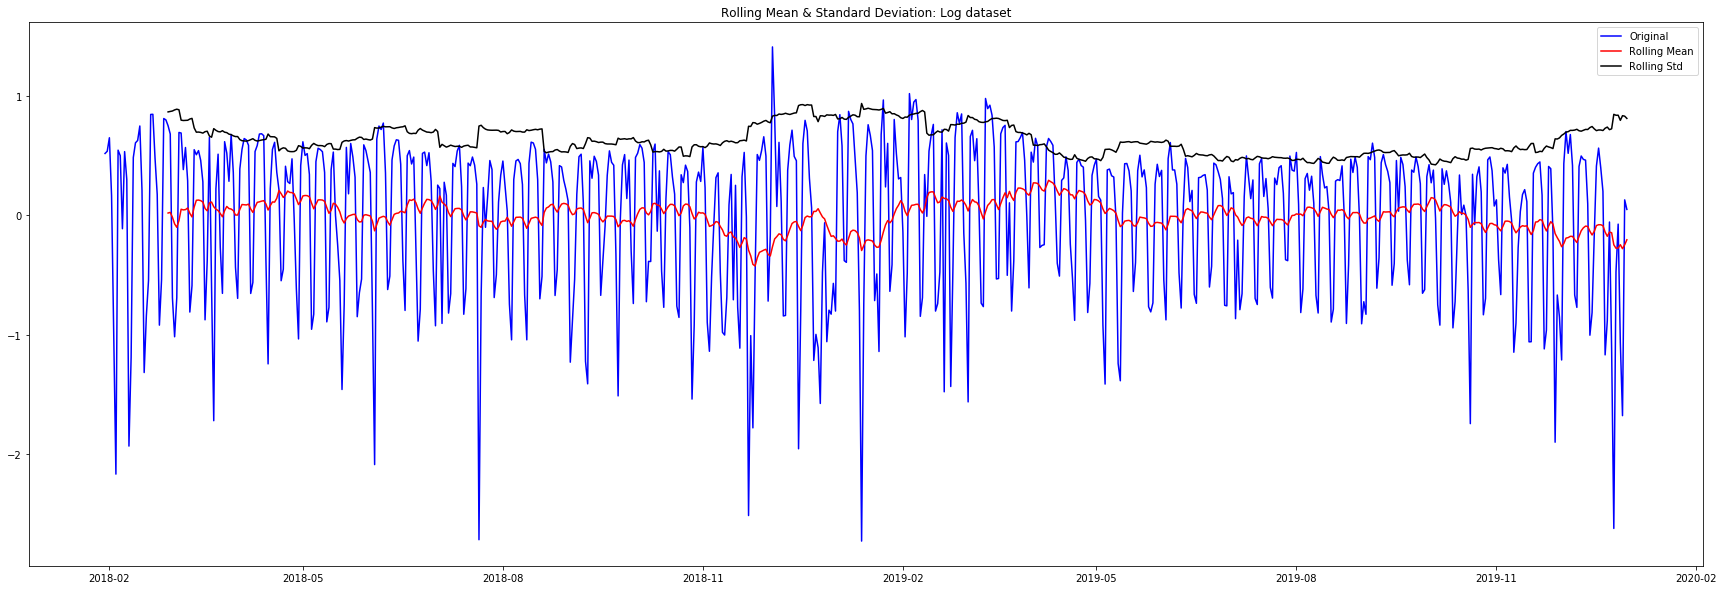

ADF Statistic: -3.811579266087317
p-value: 0.002791041144499671
Critical Values:
	1%: -3.4400031721739515
	5%: -2.865799725091594
	10%: -2.569038427768166


In [36]:
# take the log values
df_log = np.log(df)

rolling_mean = df_log.rolling(window=30).mean()
df_log_minus_mean = df_log - rolling_mean
df_log_minus_mean.dropna(inplace=True)
get_stationarity(df_log_minus_mean, 'Rolling Mean & Standard Deviation: Log dataset', 
                 '../Figures/rolling_mean_std_log_values.png')

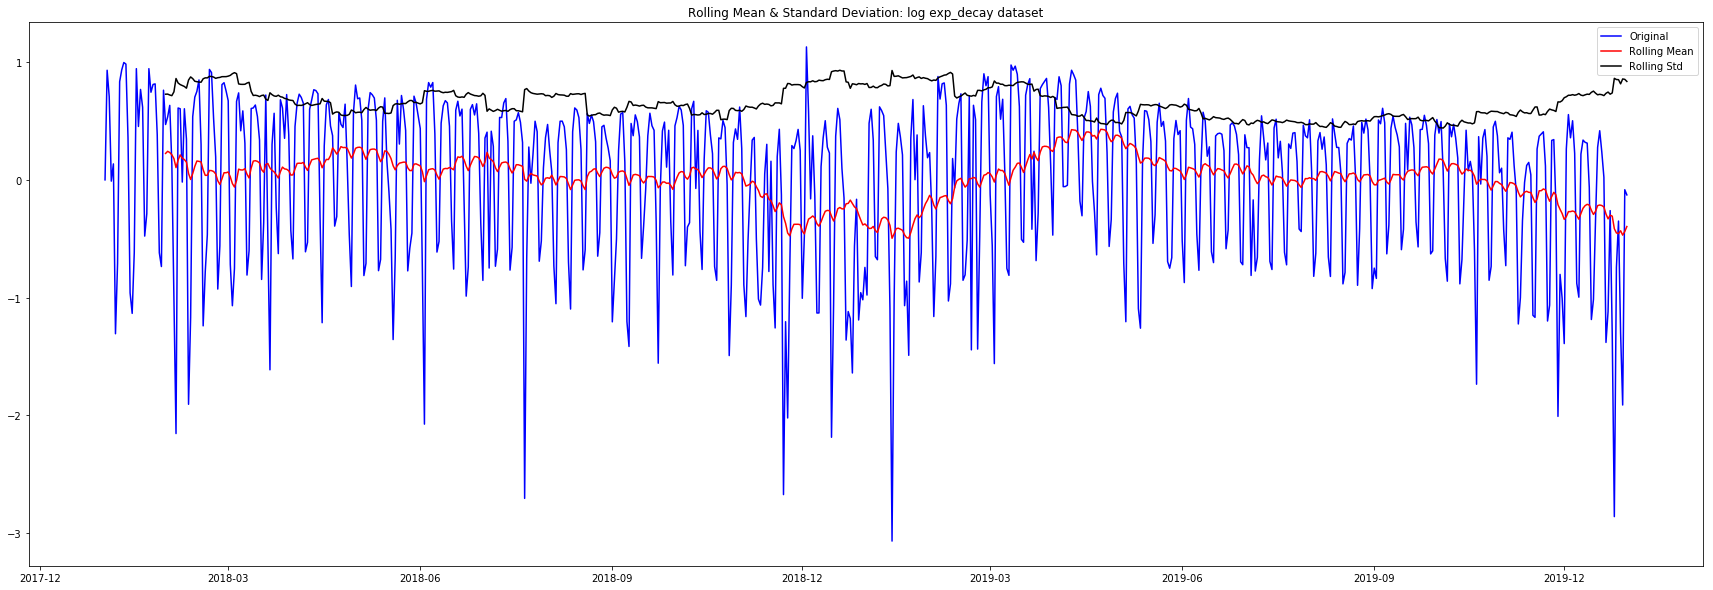

ADF Statistic: -1.8753533629939767
p-value: 0.34374299712346834
Critical Values:
	1%: -3.439606888036868
	5%: -2.865625121924057
	10%: -2.5689454046801052


In [37]:
# stationarity check : exp_decay
rolling_mean_exp_decay = df_log.ewm(halflife=30, min_periods=0, adjust=True).mean()
df_log_exp_decay = df_log - rolling_mean_exp_decay
df_log_exp_decay.dropna(inplace=True)
get_stationarity(df_log_exp_decay, 'Rolling Mean & Standard Deviation: log exp_decay dataset',
                 '../Figures/rolling_mean_std_log_exp_decay.png')

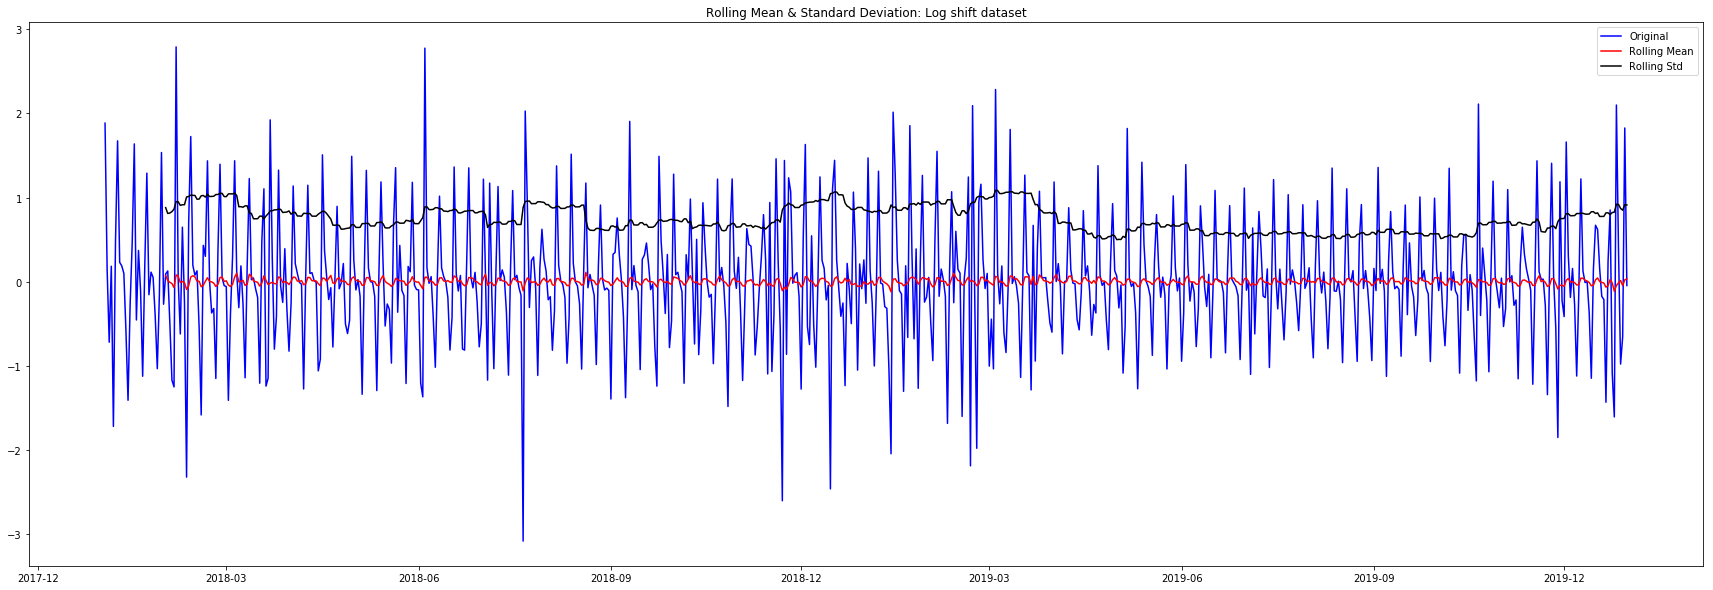

ADF Statistic: -9.342187310292509
p-value: 8.736654959935992e-16
Critical Values:
	1%: -3.439620010600208
	5%: -2.8656309041017756
	10%: -2.5689484851894413


In [38]:
# stationarity check : log shift
df_log_shift = df_log - df_log.shift()
df_log_shift.dropna(inplace=True)
get_stationarity(df_log_shift, 'Rolling Mean & Standard Deviation: Log shift dataset',
                 '../Figures/rolling_mean_std_log_shift.png')

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


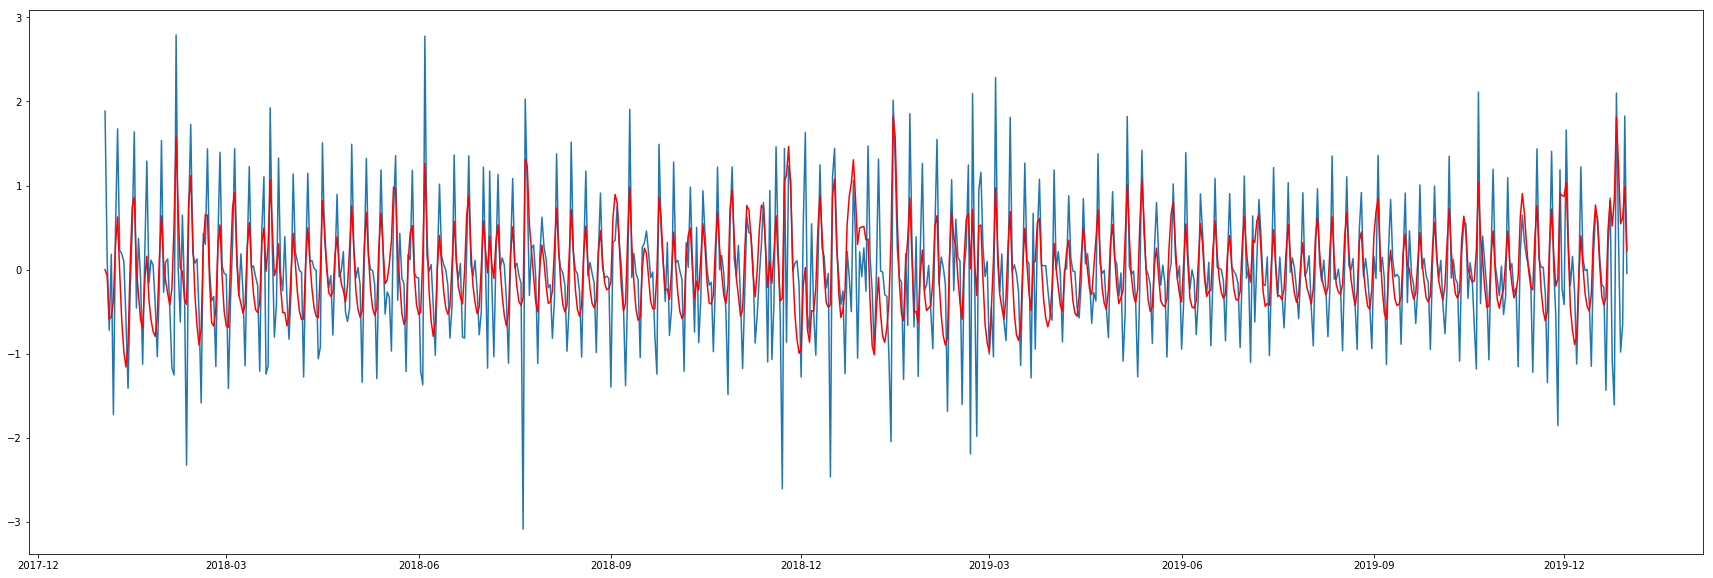

In [71]:
# # ARIMA model implementation
# decomposition = seasonal_decompose(df_log) 
# model1 = ARIMA(df_log, order=(3,1,2))
# results1 = model1.fit(disp=-1)
# fig, ax = plt.subplots(figsize=(30,10))
# plt.plot(df_log_shift)
# plt.plot(results1.fittedvalues, color='red')


# ARIMA model implementation
decomposition = seasonal_decompose(df_log) 
model2 = ARIMA(df_log, order=(2,1,2))
results2 = model2.fit(disp=-1)
fig, ax = plt.subplots(figsize=(30,10))
plt.plot(df_log_shift)
plt.plot(results2.fittedvalues, color='red')

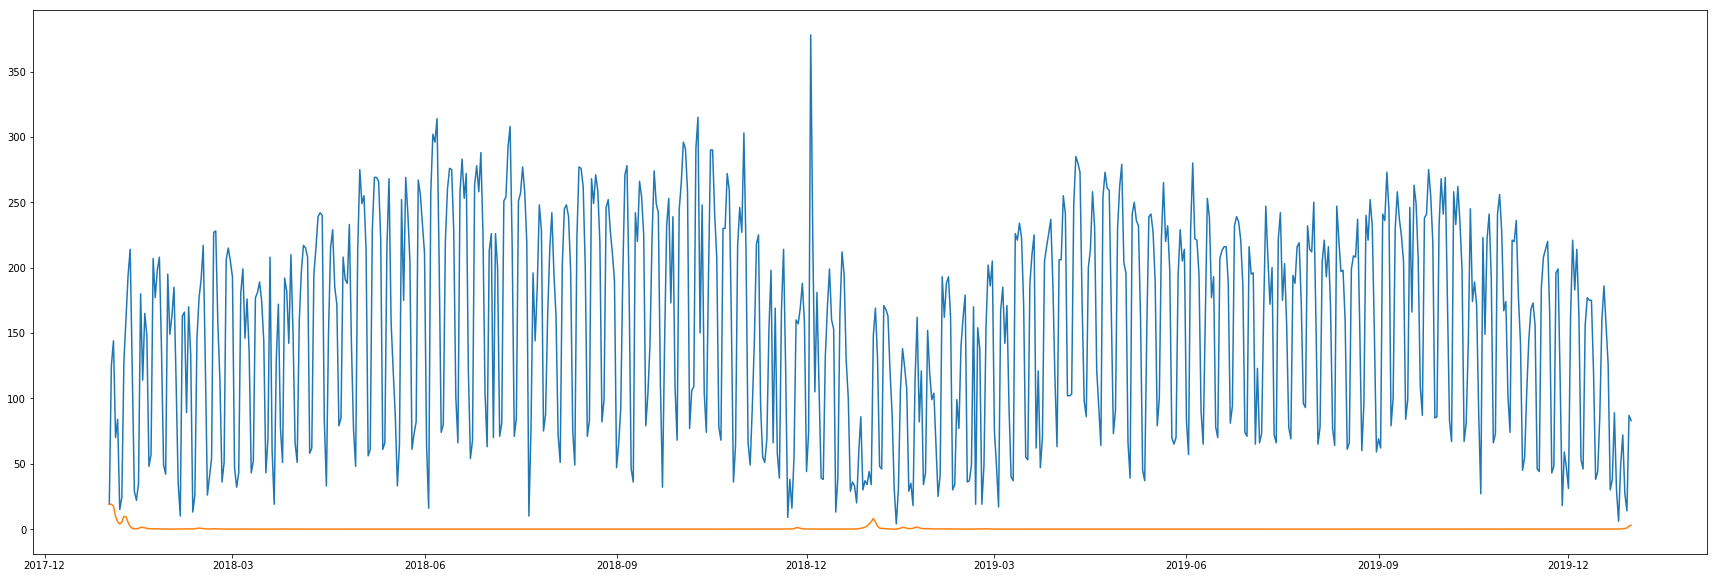

In [72]:
predictions_ARIMA_diff = pd.Series(results2.fittedvalues, copy=True)
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_log = pd.Series(df_log['number of users'].iloc[0], index=df_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum, fill_value=0)
predictions_ARIMA = np.exp(predictions_ARIMA_log)
fig, ax = plt.subplots(figsize=(30,10))
plt.plot(df)
plt.plot(predictions_ARIMA)

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


Figure(432x288)


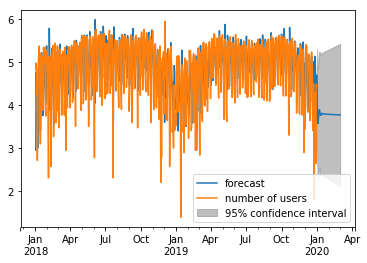

In [73]:
ade = results2.plot_predict(1, 790)
print(ade)

In [74]:
# forecast validation
# read the test data actual
test_df = pd.read_csv('../data/member_daily_testing.csv',  parse_dates = ['date'], index_col = ['date'])

#read test data with all columns
test_regular = pd.read_csv('../data/member_daily_testing.csv',  header=0, names = ['date', 'number of users'])

# get only the duration column for prediction data (2020 jan and 2020 feb)
test_regular = test_regular.drop(['date'], axis=1)

# get log value for stationarity
test_df_log = np.log(test_df)


In [54]:
# # forcast next two months
# pred_1 = results1.forecast(steps=60)[0]
# # print(pred_1)
# plt.title("Prediction for next two months : model 1")
# plt.xlabel('number of users(log)')
# plt.ylabel('prediction date')
# plt.plot(pred_1)

# plt.savefig('../Figures/forcasting_registered_user_mdl1.png')

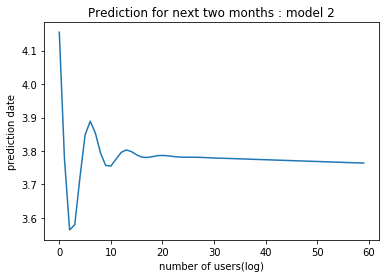

In [75]:
pred_2 = results2.forecast(steps=60)[0]
# print(pred)
plt.title("Prediction for next two months : model 2")
plt.xlabel('number of users(log)')
plt.ylabel('prediction date')
plt.plot(pred_2)

plt.savefig('../Figures/forcasting_registered_user_mdl2.png')

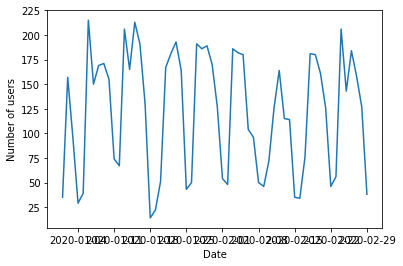

In [77]:
# plot actual data for next two month
plt.xlabel('Date')
plt.ylabel('Number of users')
plt.plot(test_df[730: len(test_df)])
plt.savefig('../Figures/forecasting_act.png')

In [79]:
# round off the durations 
pred_act =  np.round(np.exp(pred_2))

# calculate the MAPE
def MAPE_calculation():
    mape_sum = 0
    ini = 730
    
    for item in pred_act:
        act = int(test_regular[ini:(ini+1)]['number of users'])
        diff = (abs( act - int(item))/ act)
    #     print(item, act, diff)
        mape_sum = (mape_sum+ diff)
        ini+=1
#     mape_sum = MAPE_calculation()        
    mape = mape_sum/len(test_regular)
    print('MAPE sum is' , mape_sum, 'and the MAPE is', mape)    
#     return mape_sum

        
# calculate MSE
def MSE_calculation():
    
    mse_sum = 0
    ini = 730
    for item in pred_act:
        act = int(test_regular[ini:(ini+1)]['number of users'])
        diff = ( act - int(item)) ** 2
    #     print(item, act, diff)
        mse_sum = (mse_sum+ diff)
        ini+=1
        
#     return mse_sum
#     mse_sum = MSE_calculation()
    mse = mse_sum / len(test_regular)
    print('MSE sum is' , mse_sum, 'and the MSE is', mse)

        


In [80]:
MAPE_calculation()

MAPE sum is 35.4905990161992 and the MAPE is 0.04492480888126481
